# Different Approaches to Creating an Ensemble

Once an ensemble is created, and each method in the ensemble predicts the outcome, we need to decide how to use these outputs to deliver the ensemble prediction. 

(1) Simple averaging

> For regression, take a simple average of the outputs, median prediction (which is resilient to outliers), or use a weighted average (e.g. based on accuracy or input data quality of the models)

> For classification, we use voting: choose the most popular vote among the classification results. Choosing the majority-vote is also called hard voting. Using a weighted approach is called soft voting - when all classifiers in the ensemble are able to estimate class probabilities (predict_proba() method), then scikit-learn can predict the class with the highest class probability, averaged over all the individual classifiers. Set ```voting=hard``` or ```voting=soft``` to switch between the two options. 

>> for SVC, set```probability=True``` then SVC class can use cross-validation to estimate class probabilities, and adds a predict_proba() method. 

(2) Bagging: averaging accross multiple random data samples (== bootstrap aggregating)

(3) Boosting: improving the errors in each iteration of the model. 


### Voting Classifiers

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import numpy as np
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC

In [3]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


Voting classifier slightly outperformed the individual classifiers. 

### (1) Voting classifier with ```voting=soft```

In [6]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [7]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


Use soft voting setting, the voting classifier achieves 91.2% accuracy, higher than the individual classifiers, as well as the ```voting=hard``` version.

### (2) Bagging ensembles

When sampling is performed with replacement, this method is called bagging (short for bootstrap aggregating, In statistics, resampling with replacement is called bootstrapping). 

> ```bootstap=True``` and ```max_samples``` sample the data

> ```max_features``` and ```bootstrap_features``` sample the features. Particulary useful when dealing with high-dimensional data (e.g. images)

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.904


Note: The ```BaggingClassifier``` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a ```predict_proba()``` method), which is the case with Decision Tree classifiers.

#### Single Decision Tree:

In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


#### Plotting the decision boundary for decision tree and bagging models

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

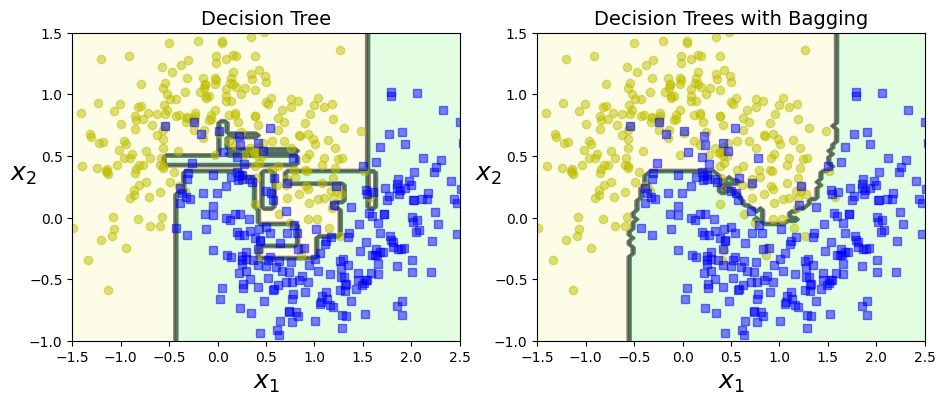

In [13]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

#### Comparison of the decision tree and bagging model

Ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular). Ensemble has a smaller variance because we are using bootstraping to vary the training dataset content.

#### Reminder: The Bias/Variance Trade-off

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

(1) Bias: This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.
The bias is a measure of how close the model can capture the mapping function between inputs and outputs. It captures the rigidity of the model: the strength of the assumption the model has about the functional form of the mapping between inputs and outputs.

(2) Variance: This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).The variance of the model is the amount the performance of the model changes when it is fit on different training data.
It captures the impact of the specifics the data has on the model.

(3) Irreducible error: Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off.

In [14]:
bag_clf.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': 42,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(random_state=42),
 'max_features': 1.0,
 'max_samples': 100,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Random Forest

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. At each node only a random subset of the features is considered for splitting.

The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance.

In [15]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16
                                 , n_jobs=-1,random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [16]:
print(accuracy_score(y_test, y_pred_rf))

0.912


In [18]:
bag_clf = BaggingClassifier(
         DecisionTreeClassifier(max_leaf_nodes=16
                                ,random_state=42),
         n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

In [19]:
print(accuracy_score(y_test, y_pred_bag))

0.912


### (3) Boosting

The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting.

Review the Ensemble_PersonalLoan example jupyter notebook.